# Trasnformer Testing

In [15]:
dataset = 'looperman'
class Config:
    cuda = 0
    d_model = 512
    transformer_n_layer = 4
    checkpoint_dir = f'/home/lego/NAS189/home/VQVAE/{dataset}/params'
    transformer_checkpoint_dir = f'/home/lego/NAS189/home/VQVAE_transformer/{dataset}/params'
    data_path = "/home/lego/NAS189/home/looperman/all/mel_80_256"
    embed_dim = 80
    n_embed = 64
    latent_loss_weight = 0.1
    bypass = False
    encoder_scale_factors =[0.5, 0.5, 0.5, 0.5]
    decoder_scale_factors =[2, 2, 2, 2]
args = Config()

import numpy as np
n_latent = int(np.array(args.encoder_scale_factors).prod() * 256)
runs = str(args.embed_dim)+'_'+str(args.n_embed)+'_'+ str(args.latent_loss_weight).split('.')[-1] + '_' + str(n_latent)

In [16]:
import torch
import os
from model import VQVAE
from model.transformer import VQTransformer
import numpy as np
import re

genre_id = 22

def best_fname(path):
    fl = os.listdir(path)
    fl.sort(key=lambda f: int(re.sub('\D', '', f)))
    return fl[-1]

device = torch.device(f'cuda:{args.cuda}')
model = VQVAE(
    feat_dim = 80, 
    z_dim = args.embed_dim, 
    encoder_scale_factors = args.encoder_scale_factors, 
    decoder_scale_factors = args.decoder_scale_factors, 
    embed_dim = args.embed_dim, 
    n_embed = args.n_embed,
).to(device)

transformer = VQTransformer(
            d_model=args.d_model, 
            n_layer=args.transformer_n_layer, 
            n_embed=args.n_embed,
            softmax_temp=None
).to(device)

ckpt = torch.load(
        os.path.join(args.checkpoint_dir, runs, best_fname(os.path.join(args.checkpoint_dir, runs))), 
        map_location= lambda storage, loc: storage
)
model.load_state_dict(ckpt['model'])

ckpt = torch.load(
        os.path.join(args.transformer_checkpoint_dir, runs+'_genre', best_fname(os.path.join(args.transformer_checkpoint_dir, runs+'_genre'))), 
        map_location= lambda storage, loc: storage
)
transformer.load_state_dict(ckpt['transformer'])

mean_fp = os.path.join(args.data_path, f'mean.mel.npy')
std_fp = os.path.join(args.data_path, f'std.mel.npy')
mean = torch.from_numpy(np.load(mean_fp)).float().to(device).view(1, 80, 1)
std = torch.from_numpy(np.load(std_fp)).float().to(device).view(1, 80, 1)

model.eval()
transformer.eval()
sample_size = 10
with torch.no_grad():
    gen, pl, g = transformer.evaluate(sample_size, n_latent, model.quantize, device, genre_id, threshold_p=1) #[n_sample, L, embed_dim]
    gen = model.decoder(gen.permute(0,2,1))
    norm = gen.data.clone()
    gen = gen * std + mean 
print(gen.shape)
print(runs)
print(best_fname(os.path.join(args.checkpoint_dir, runs)))
print(best_fname(os.path.join(args.transformer_checkpoint_dir, runs)))

torch.Size([10, 80, 256])
80_64_1_16
000600.pt
001000.pt


## image

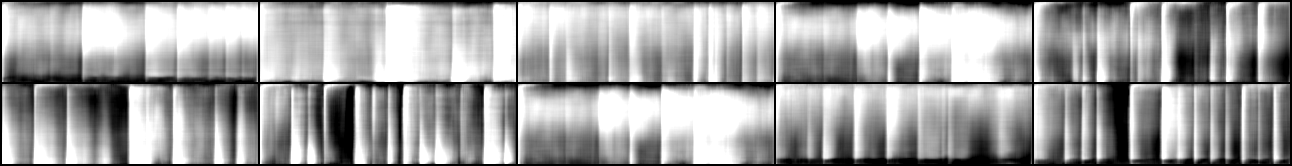

In [17]:
import torchvision
import IPython.display as ipa

torchvision.utils.save_image(
                norm.unsqueeze(1),
                os.path.join('samples/',str(0).zfill(5)+".png"),
                nrow=sample_size//2,
                normalize=True,
                range=(-1, 1),
            )
ipa.Image('samples/00000.png')

In [21]:
from mel2wav.modules import Generator
import IPython.display as ipa
from utils.tester import VQVAE_Tester, Mel2Wav
import soundfile as sf

mel2wav = Mel2Wav(device)
pred_audio = mel2wav(gen)
# for i, audio in enumerate(pred_audio):
#     sf.write('samples/'+str(i)+'.wav', audio.transpose((1,0)), 44100)
ipa.Audio(pred_audio[9,:,:88000],rate=44100)

In [19]:
pred_audio.shape

(10, 1, 89600)

In [184]:
from mel2wav.modules import Generator
import IPython.display as ipa
from utils.tester import VQVAE_Tester, Mel2Wav
import soundfile as sf
import random
i = random.randint(0,2000)
print(i)
una = torch.tensor(np.load(f'/home/lego/NAS189/home/VQVAE_transformer/generate/unagan/{i}.npy')).to(device).unsqueeze(0)
mel2wav = Mel2Wav(device)
pred_audio = mel2wav(una)
# for i, audio in enumerate(pred_audio):
#     sf.write('samples/'+str(i)+'.wav', audio.transpose((1,0)), 44100)
ipa.Audio(pred_audio[0,:,:],rate=44100)

1601


In [88]:
genres.index('Blues')

38

## VQ Testing

In [7]:
from utils.tester import VQVAE_Tester, Mel2Wav
from model.vqvae import VQVAE
import data
import torch
import os 
import numpy as np
import IPython.display as ipa

device = torch.device(f'cuda:{args.cuda}')
vqvae = VQVAE(
        feat_dim = 80, 
        z_dim = args.embed_dim, 
        encoder_scale_factors = [0.5, 0.5, 0.5, 0.5], 
        decoder_scale_factors = [2, 2, 2, 2], 
        embed_dim = args.embed_dim, 
        n_embed = args.n_embed,
    ).to(device)

tr_dataloader, num_tr, va_dataloader, num_va = data.get_loop_datasets(
    args.data_path,
    "",
    50,
    0.2,
)

mean_fp = os.path.join(args.data_path, f'mean.mel.npy')
std_fp = os.path.join(args.data_path, f'std.mel.npy')
mean = torch.from_numpy(np.load(mean_fp)).float().to(device).view(1, 80, 1)
std = torch.from_numpy(np.load(std_fp)).float().to(device).view(1, 80, 1)

tester = VQVAE_Tester(
        checkpoint_dir = f'/home/lego/NAS189/home/VQVAE/params/{args.embed_dim}_{args.n_embed}/',
        ckpt_id = '650',
        model = vqvae,
        loader = va_dataloader,
        mean = mean,
        std = std, 
        device = device,
    )

mel2wav = Mel2Wav(device)

with torch.no_grad():
    pred_audio, orig_audio, _id = tester()
    pred_audio = mel2wav(pred_audio)
    orig_audio = mel2wav(orig_audio)
print(_id)

tensor([[223, 176,  88,  40, 193, 145, 141, 193, 152, 152, 104, 202,  99,  81,
           6,  31],
        [  5,  25,  64,  78,   0, 137, 131,  75,  57,  62,   3, 132,  15,  74,
         238, 230],
        [253,  30, 103,  37,  96, 139, 103,  61,  33, 157,  64,   5, 105, 106,
         103, 216],
        [106,  11,  18, 249,  70, 103,  71,  28, 111, 225,  43, 235,  71,  30,
         178, 177],
        [ 40,  82,   3,  40,  20,  87, 103,  50,  51,  62,  61,  82,  67, 109,
          49, 229],
        [157, 132, 253, 212, 147,  76, 253, 246, 147, 132,  49, 246, 223,  76,
         253, 246],
        [122, 202, 157, 138, 251,  57, 251, 146,  63, 144, 167, 156, 155, 126,
          63, 175],
        [139,  45,  28,  14, 195,  41, 150, 237, 180,  36, 149,  18, 195, 105,
          12, 128],
        [127,  22, 151,  37,  12, 108, 151,  97,  43,  22, 151,  37,  57, 108,
         151,  97],
        [  4, 193, 199, 149, 150,  61,  67,   6,  54,   4,  23, 199, 149, 247,
          48,  99],
        [2

In [3]:
ipa.Audio(pred_audio[2],rate=44100)

In [17]:
pred_audio.shape

(50, 1, 65536)

In [4]:
ipa.Audio(orig_audio[2],rate=44100)

In [36]:
print(_id[14])

tensor([17, 10, 61,  0, 42, 17, 10, 34, 10, 16, 23, 54, 21, 61, 42, 13, 34, 13,
         9, 23], device='cuda:2')


In [5]:
ids = _id.detach().cpu().numpy().flatten()
d = [0] * 512
for i in ids:
    d[i] += 1
d

[35,
 21,
 19,
 12,
 35,
 21,
 8,
 11,
 14,
 28,
 10,
 13,
 24,
 21,
 12,
 6,
 31,
 10,
 3,
 15,
 10,
 18,
 9,
 0,
 0,
 0,
 0,
 11,
 15,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 25,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 30,
 0,
 0,
 0,
 0,
 17,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 32,
 0,
 21,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 32,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 34,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 32,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 20,
 0,
 0,
 0,
 0,
 0,
 20,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 21,
 0,
 0,
 0,
 0,
 0,
 0,
 25,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [6]:
c = c_ = 0
for idx in d:
    if idx == 0:
        c_ += 1
    else:
        c += 1
print(c/128)

0.3203125


In [17]:

import torch
from utils.tester import VQVAE_Tester, Mel2Wav
from model.vqvae import VQVAE
import IPython.display as ipa
import os
import numpy as np
device = torch.device(f'cuda:{args.cuda}')
mel2wav = Mel2Wav(device)

mean_fp = os.path.join(args.data_path, f'mean.mel.npy')
std_fp = os.path.join(args.data_path, f'std.mel.npy')
mean = torch.from_numpy(np.load(mean_fp)).float().to(device).view(1, 80, 1)
std = torch.from_numpy(np.load(std_fp)).float().to(device).view(1, 80, 1)

vqvae = VQVAE(
        feat_dim = 80, 
        z_dim = args.embed_dim, 
        encoder_scale_factors = [0.5, 0.5, 0.5, 0.5], 
        decoder_scale_factors = [2, 2, 2, 2], 
        embed_dim = args.embed_dim, 
        n_embed = args.n_embed,
    ).to(device)
testing_code = torch.tensor([47,  37,  47,  37, 60,  37, 47, 37,
                             110,  110,  110,  110,  40,  10,  10,  79])[None,:].long().to(device)
# testing_code = torch.ones(1,20).fill_(90).long().to(device)
# testing_code = torch.tensor([[92]*16]).long().to(device)
# testing_code[:,::4] = 112
checkpoint_dir = f'/home/lego/NAS189/home/VQVAE/params/{args.embed_dim}_{args.n_embed}/'
print(testing_code)
ckpt_id = "950"
ckpt = torch.load(checkpoint_dir+ckpt_id.zfill(6)+'.pt')
vqvae.load_state_dict(ckpt['model'])

pred_quant = vqvae.quantize.embed_code(testing_code)
x = vqvae.decoder(pred_quant.permute(0,2,1))
pred_audio = mel2wav(x * std + mean)
ipa.Audio(pred_audio[0,:,:65536//2],rate=44100)

tensor([[ 47,  37,  47,  37,  60,  37,  47,  37, 110, 110, 110, 110,  40,  10,
          10,  79]], device='cuda:2')


In [50]:
import torchvision
torchvision.utils.save_image(
                x[0,:128],
                '3'+".png",
                nrow=1,
                normalize=True,
                range=(-1, 1),
            )


In [40]:
x.shape

torch.Size([1, 80, 256])

## Transformer causual Testing

In [2]:
from utils.tester import VQVAE_Tester, Mel2Wav, Transformer_Tester
from model.vqvae import VQVAE
from model.transformer import VQTransformer

import data
import torch
import os 
import numpy as np

device = torch.device(f'cuda:{args.cuda}')
vqvae = VQVAE(
        feat_dim = 80, 
        z_dim = args.embed_dim, 
        encoder_scale_factors = [0.5, 0.5, 0.5, 0.5], 
        decoder_scale_factors = [2, 2, 2, 2], 
        embed_dim = args.embed_dim, 
        n_embed = args.n_embed,
    ).to(device)

transformer = VQTransformer(
            d_model=args.d_model, 
            n_layer=args.transformer_n_layer, 
            n_embed=args.n_embed,
            softmax_temp=None
    ).to(device)


tr_dataloader, num_tr, va_dataloader, num_va = data.get_loop_datasets(
    "/home/lego/NAS189/homes/allenhung/Project/loop-generation/data/freesound/drum_audio/mel_80_320",
    "",
    4,
    0.2,
)

mean_fp = os.path.join(args.data_path, f'mean.mel.npy')
std_fp = os.path.join(args.data_path, f'std.mel.npy')
mean = torch.from_numpy(np.load(mean_fp)).float().to(device).view(1, 80, 1)
std = torch.from_numpy(np.load(std_fp)).float().to(device).view(1, 80, 1)

tester = Transformer_Tester(
        checkpoint_dir = f'/home/lego/NAS189/home/VQVAE/params/{args.embed_dim}_{args.n_embed}/',
        ckpt_id = "950",
        model = vqvae,
        loader = va_dataloader,
        mean = mean,
        std = std,
        transformer = transformer,
        transformer_checkpoint_dir = args.transformer_checkpoint_dir, 
        transformer_ckpt_id = '250',
        device = device,
    )
with torch.no_grad():
    p, _id = tester()
p

tensor([[238,  16,  39,  10, 418,  10,  37,  27, 481, 418, 481,  39,  38,  31,
         418, 481,  37,  39, 282, 481],
        [158, 463,  25,   8, 132, 503, 463,  19,   8, 463, 454, 463,  19, 290,
         290, 503, 463,  19, 379, 290],
        [ 20,  26,  37,  28,  18, 502,  36,  90,  18,  90, 500, 418,  13,   6,
          18, 223, 502,  27, 362, 282],
        [502, 113,  13,  26, 390,  28,  90, 350, 282, 132,  15,  25, 379,  23,
         290, 245,  21, 282, 503, 156]], device='cuda:2')
tensor([[512, 238,  16,  39,  10, 418,  10,  37,  27, 481, 418, 481,  39,  38,
          31, 418, 481,  37,  39, 282],
        [512, 158, 463,  25,   8, 132, 503, 463,  19,   8, 463, 454, 463,  19,
         290, 290, 503, 463,  19, 379],
        [512,  20,  26,  37,  28,  18, 502,  36,  90,  18,  90, 500, 418,  13,
           6,  18, 223, 502,  27, 362],
        [512, 502, 113,  13,  26, 390,  28,  90, 350, 282, 132,  15,  25, 379,
          23, 290, 245,  21, 282, 503]], device='cuda:2')


/home/lego/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


tensor([[[2.4175e-04, 3.1259e-06, 3.0833e-03,  ..., 4.7867e-05,
          1.5500e-05, 2.0857e-05],
         [3.2727e-05, 4.8293e-06, 5.4884e-04,  ..., 6.5809e-05,
          5.1949e-05, 3.3321e-05],
         [1.1434e-05, 6.6336e-05, 1.9532e-03,  ..., 3.2441e-05,
          3.7257e-05, 3.6660e-05],
         ...,
         [1.6639e-08, 1.9954e-10, 2.7039e-07,  ..., 9.8317e-09,
          1.4041e-08, 1.2720e-08],
         [2.1379e-09, 4.8367e-08, 5.6862e-07,  ..., 7.9472e-09,
          1.3215e-08, 9.1852e-09],
         [1.3533e-05, 5.2005e-05, 3.8685e-06,  ..., 1.2504e-05,
          3.0946e-05, 2.9804e-05]],

        [[2.4175e-04, 3.1259e-06, 3.0833e-03,  ..., 4.7867e-05,
          1.5500e-05, 2.0857e-05],
         [2.2156e-05, 1.9798e-05, 8.7474e-03,  ..., 6.4257e-05,
          4.3344e-05, 4.2612e-05],
         [1.0151e-05, 2.2347e-05, 6.3839e-04,  ..., 6.9117e-05,
          3.1975e-05, 2.4907e-05],
         ...,
         [2.8060e-09, 1.7095e-07, 1.7224e-10,  ..., 7.5103e-09,
          1.743

In [31]:
import json
import os
import numpy as np
D = {}
new_meta = {}
with open('/home/lego/NAS189/homes/ytsrt/Looperman_v1/meta_data.json') as f:
    meta = json.load(f)
for _id in meta:
    g = meta[_id]['genre']
    if g not in D:
        D[g] = 1
    else:
        D[g] += 1
        
    new_meta[_id] = g
genres = list(D.keys())[:-1]

In [6]:
new_meta[' Bath Brain_Planetjazzbass_26th Mar 2009_120_Electronic_Drum_Unknown']

'Electronic'

In [53]:
import pickle
from tqdm import tqdm

path = '/home/lego/NAS189/home/looperman/all/mel_80_256'
fl = os.listdir(path)
fl = [f for f in fl if not 'mean' in f and not 'std' in f and not 'dataset'in f]
dataset = []

for f in tqdm(fl):
    if np.isnan(np.load(os.path.join(path, f))).any():
        continue
    _f = f.strip('.npy').rsplit('_', 1)[0]
    try:
        g = new_meta[_f]
        dataset += [(f, genres.index(g))]
        
    except:
        print(_f)

# with open(os.path.join('/home/lego/NAS189/home/looperman/all/dataset.pkl'), 'wb') as f:
#     pickle.dump(dataset, f)

  3%|█▋                                                  | 4136/127859 [00:05<02:22, 866.21it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


  4%|██▏                                                 | 5452/127859 [00:07<03:24, 597.29it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


  5%|██▊                                                 | 6903/127859 [00:08<02:31, 796.57it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 12%|██████                                             | 15195/127859 [00:20<02:30, 747.49it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 27%|█████████████▊                                     | 34473/127859 [00:44<01:52, 833.06it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 29%|██████████████▉                                    | 37541/127859 [00:48<01:40, 895.79it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 34%|█████████████████▍                                 | 43742/127859 [00:57<01:55, 728.11it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 38%|███████████████████▍                               | 48725/127859 [01:03<01:44, 756.58it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 38%|███████████████████▌                               | 49015/127859 [01:03<01:28, 893.87it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 63%|████████████████████████████████▎                  | 81114/127859 [01:44<00:49, 936.88it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 81%|████████████████████████████████████████▍         | 103473/127859 [02:12<00:35, 686.79it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 86%|███████████████████████████████████████████▏      | 110346/127859 [02:22<00:25, 679.70it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 87%|███████████████████████████████████████████▎      | 110719/127859 [02:23<00:20, 830.88it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 93%|██████████████████████████████████████████████▍   | 118659/127859 [02:35<00:11, 826.65it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


 95%|███████████████████████████████████████████████▎  | 121103/127859 [02:39<00:07, 904.18it/s]

Cinematic Drums Barcelona 01_BernieFernandez_18th Dec 2016_53_Cinematic_Drum_Unknown


100%|██████████████████████████████████████████████████| 127859/127859 [02:48<00:00, 760.80it/s]


In [54]:
with open(os.path.join('/home/lego/NAS189/home/looperman/all/dataset.pkl'), 'wb') as f:
    pickle.dump(dataset, f)

In [29]:
import pickle
import os
import numpy as np
from tqdm import tqdm
new_dataset = []
_D = np.zeros(66, dtype=int)
with open('/home/lego/NAS189/home/looperman/all/genre_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
    G = [x[1] for x in dataset]
for g in G:
    _D[g] += 1
_D

array([35049,  2097,  5156,   350,  1291,    49,   678,   229,    20,
         589,   916,  5059,  1781,  4105,   400,   399,   974,   137,
       15844,   350,   191,  1676,   661,   263,  9246,   214,   134,
         905,    10,  8500,  1986,  6058,   623,  1634,   207,  1062,
        2463,  1607,   184,   778,  2290,  1695,  1413,    25,    69,
        2230,   723,   163,     5,   213,   120,   608,   329,   156,
          61,   466,    17,   322,  1145,   721,   304,   322,   453,
           8,    14,    88])

In [7]:
import pickle
import os
import numpy as np
from tqdm import tqdm
new_dataset = []
with open('/home/lego/NAS189/home/looperman/all/dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
    train_dataset = dataset[:110000]
    test_dataset = dataset[110000:]
   
with open(os.path.join('/home/lego/NAS189/home/looperman/all/train_dataset.pkl'), 'wb') as f:
    pickle.dump(train_dataset, f)
with open(os.path.join('/home/lego/NAS189/home/looperman/all/test_dataset.pkl'), 'wb') as f:
    pickle.dump(test_dataset, f)      

In [64]:
import pickle
with open('/home/lego/NAS189/home/looperman/all/mel_80_256/genre_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
    dataset_ids = [x[0] for x in dataset]
    print(dataset[70:75])

[('PANDA Trap Drums Without 808_DasDimaBeatz_21st May 2020_150_Trap_Drum_Gm_9.npy', 0), ('Pebble In My Shoe No Kick_eluterius_14th Sep 2019_110_Electronic_Drum_Unknown_2.npy', 11), ('Drumm_AndreyLoys_16th Jan 2020_120_Trap_Drum_Cm_4.npy', 0), ('Lo-fi Drum Loop_prodbyVLTNO_15th Aug 2019_80_Lo-Fi_Drum_Unknown_1.npy', 4), ('Cool B 2_clinthammerMUSIC_6th Jun 2010_94_Chill Out_Drum_Unknown_3.npy', 45)]


In [32]:
genres[11]

'Electronic'

In [63]:
import pickle
import os
import numpy as np

with open('/home/lego/NAS189/homes/allenhung/Project/loop-generation/style-based-gan-drum/training_data_one_bar_all/dict_one_bar.pickle', 'rb') as f:
    dict_1_bar = pickle.load(f)
dict_1_bar

{'Dry Dubstep Drums_Mararity_26th Jan 2014_140_Dubstep_Drum_Unknown_1.npy': 'Dubstep',
 'SIMPLE CRUNK DRUM LOOP_kristijann_13th Feb 2015_70_Crunk_Drum_Unknown_8.npy': 'Crunk',
 'CCD Big Kick Build 140_Spivkurl_7th Dec 2013_140_Dubstep_Drum_Unknown_2.npy': 'Dubstep',
 'Rhythm 140_xxxZephyrxxx_6th Aug 2015_140_Techno_Drum_Unknown_14.npy': 'Techno',
 'Disturbeats 424 Of 666_flsouto_3rd Mar 2020_128_Industrial_Drum_Unknown_2.npy': 'Industrial',
 'Awesome Dubstep Sample _blupsworld_6th Apr 2011_140_Dubstep_Drum_Unknown_2.npy': 'Dubstep',
 'Downtempo Ambient Drums_danke_21st Dec 2014_80_Ambient_Drum_Unknown_1.npy': 'Ambient',
 'Bubble Drum_mhyst_15th Sep 2009_110_Ambient_Drum_Unknown_1.npy': 'Ambient',
 'Real Game Changer This Guy Is - 160 BPM_BLACKMANSTA10_2nd Apr 2018_160_Trap_Drum_Unknown_10.npy': 'Trap',
 'Drums Over Oscillator 01_Psychotropic_Circle_8th Nov 2007_100_Funk_Drum_Unknown_5.npy': 'Funk',
 'Hard Drums_ferdelar_26th Sep 2018_140_Trap_Drum_B_8.npy': 'Trap',
 'Disturbeats 495 Of

In [33]:
import numpy as np
import soundfile as sf
from tqdm import tqdm
root = '/home/lego/NAS189/home/codify/data/drums/audio/target/'
output = '/home/lego/NAS189/home/codify/data/drums/audio_24s/target/'
import os
l = 8192 * 4 * 4 * 8
fl = os.listdir(root)
for f in tqdm(fl):
    y, sr = sf.read(os.path.join(root,f))
    start = 0
    idx = 0
    while True:
        if start+l > y.shape[0]:
            seg = y[start:start+l,:]
            seg = np.pad(seg, ((0, l-seg.shape[0]), (0,0)), 'constant', constant_values=0)
            sf.write(os.path.join(output,f.strip('.wav')+f'_{idx}.wav'), seg, 44100)
            break
        else:
            seg = y[start:start+l,:]
            sf.write(os.path.join(output,f.strip('.wav')+f'_{idx}.wav'), seg, 44100)
            idx += 1
            start += l
        
        
    

100%|█| 346/346 [04:49<00:00,  1.20it/s]


In [59]:
import os
import numpy as np
from tqdm import tqdm
output = '/home/lego/NAS189/home/codify/data/drums/audio_24s/target/'
fl = os.listdir(output)
c = 0
r = []
for f in tqdm(fl):
    y, sr = sf.read(os.path.join(output,f))
    if not np.sum(y==0) > (8192/2):
        # print(f)
        c += 1
        r.append(f)


100%|████████████████████████████████████| 3747/3747 [04:12<00:00, 14.85it/s]


In [63]:
fl = [f.replace('.wav', '.npy') for f in r]
with open('/home/lego/NAS189/home/codify/data/drums/feature/token/dataset2.pkl', 'wb') as f:
    pickle.dump(fl, f)


In [52]:
import pickle
import numpy as mp
import os
with open('/home/lego/NAS189/home/codify/data/drums/audio_24s/dataset.pkl', 'rb') as f:
    fl = pickle.load(f)
fl = [f.replace('.wav', '.npy') for f in fl]
root = '/home/lego/NAS189/home/codify/data/drums/feature/target'
r = []
for f in fl:
    dpath = os.path.join(root, f)
    y = np.load(dpath)
    r.append(np.sum(y==653))

In [69]:
import numpy as np
root = '/home/lego/NAS189/homes/lego/codify/data/drums/feature/mel/target'
fl = os.listdir(root)
dataset = []
for f in tqdm(fl):
    x = np.load(os.path.join(root,f))
    if not np.any(np.isnan(x)):
        dataset += [f]

with open('/home/lego/NAS189/homes/lego/codify/data/drums/feature/mel/dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

100%|████████████████████████████████████| 3747/3747 [00:56<00:00, 66.40it/s]


In [68]:
len(fl)

3747